# **ChurnInsight**
## **Telco Customer Churn Prediction**

## **Content**


1. **Introduction and Business Objective**

2. **Environment and Style Settings**

3. **Data Loading & Exploratory Data Analysis (EDA)**

4. **Exploratory Cleaning**

5. **Feature Engineering (Exploratory)**

6. **Controlled Experimentation**

7. **Hyperparameter Tuning**  

8. **Final Model Decision**

9. **Decision Threshold Optimization**  
   9.1 Business Context (Telecom)  
   9.2 Simple Business Cost Simulation  
   9.3 Operational Threshold Selection

10. **Final Model Interpretability**  s

11. **Insights**


## **1. Introduction and Business Objective**

**Objective**
Build an end-to-end Machine Learning solution to identify customers with a high risk of churn in a telecommunications company, enabling proactive retention and minimizing revenue loss.

**Why Churn Matters**

Customer churn has a direct economic impact, as retaining existing customers is significantly cheaper than acquiring new ones. Early identification of high-risk customers allows the business to focus retention efforts where they generate the highest value.

**Project Scope**

This notebook covers the complete Data Science workflow:

- Exploratory Data Analysis (EDA)

- Model experimentation and selection

- Class imbalance handling

- Business-driven threshold optimization

**Out of Scope**

- Real-time deployment or API implementation

- Backend or MLOps infrastructure

- Execution of customer retention actions

## **2. Environment and style settings**

In this section, we prepare the analysis tools and import the raw dataset.

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from typing import List, Dict

# Sklearn & ML Toolkit
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve, f1_score)

# Handling imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Display Settings
def set_notebook_theme():
    warnings.filterwarnings('ignore')
    sns.set_theme(style="whitegrid", palette="viridis")
    plt.rcParams.update({
        'figure.figsize': (10, 6),
        'axes.titlesize': 16,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'font.family': 'sans-serif'
    })

set_notebook_theme()
PALETTE_CHURN = ["#2ecc71", "#e74c3c"] # Green for No, Red for Yes

##**3. Data Loading & Exploratory Data Analysis (EDA)**

> **Note**  
> This notebook is designed to run in Google Colab for experimentation and analysis.  
> Data is loaded from the Colab runtime.  
> In the production pipeline, data loading is handled externally.


In [92]:
archivo = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
df_raw = pd.read_csv(archivo)

print(df_raw.shape)

(7043, 21)


Before any processing, we perform a “blind” inspection to understand how the data is structured and detect technical anomalies.

In [93]:
# Preview dataset
display(df_raw.head())

print("\n--- Technical Overview ---")
df_raw.info()

print("\n--- Categorical Cardinality ---")
for col in df_raw.select_dtypes(include='object').columns:
    if col != 'customerID':
        print(f"{col}: {df_raw[col].nunique()}")


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



--- Technical Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilli

In [94]:
for col in df_raw.columns:
    print(f"'{col}',")


'customerID',
'gender',
'SeniorCitizen',
'Partner',
'Dependents',
'tenure',
'PhoneService',
'MultipleLines',
'InternetService',
'OnlineSecurity',
'OnlineBackup',
'DeviceProtection',
'TechSupport',
'StreamingTV',
'StreamingMovies',
'Contract',
'PaperlessBilling',
'PaymentMethod',
'MonthlyCharges',
'TotalCharges',
'Churn',


The initial inspection reveals a few issues that will be addressed during the data cleaning phase:

- **TotalCharges** is stored as an object despite being a monetary variable, indicating the presence of non-numeric values.
- **SeniorCitizen** is encoded as 0/1, while other binary features use `Yes/No`, requiring standardization.
- **customerID** is a unique identifier and provides no predictive value; it will be excluded from modeling.
- The target variable **Churn** must be evaluated for class imbalance before training.


In [95]:
# Work on a copy to preserve the raw dataset
df = df_raw.copy()

# Convert TotalCharges to numeric (coerce invalid values to NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Check missing values introduced by conversion
missing_total_charges = df["TotalCharges"].isna().sum()
print(f"Missing values in TotalCharges after conversion: {missing_total_charges}")

# Impute using median to reduce sensitivity to outliers
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Standardize SeniorCitizen encoding
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1: "Yes", 0: "No"})

# Remove non-predictive identifier
df = df.drop(columns=["customerID"])

# Schema validation
df.info()


Missing values in TotalCharges after conversion: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   obj

In [96]:
# Inspect unique values to detect formatting inconsistencies
for col in df.columns:
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print("-" * 40)


Unique values in 'gender':
['Female' 'Male']
----------------------------------------
Unique values in 'SeniorCitizen':
['No' 'Yes']
----------------------------------------
Unique values in 'Partner':
['Yes' 'No']
----------------------------------------
Unique values in 'Dependents':
['No' 'Yes']
----------------------------------------
Unique values in 'tenure':
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
----------------------------------------
Unique values in 'PhoneService':
['No' 'Yes']
----------------------------------------
Unique values in 'MultipleLines':
['No phone service' 'No' 'Yes']
----------------------------------------
Unique values in 'InternetService':
['DSL' 'Fiber optic' 'No']
----------------------------------------
Unique values in 'OnlineSecurity':
['No' 'Yes' 'No internet service']

**Target Variable Analysis**

This section examines the distribution of the `Churn` variable to assess the proportion of customer attrition versus retention.  
Understanding class balance at this stage is critical, as significant imbalance may bias model training and influence metric selection.


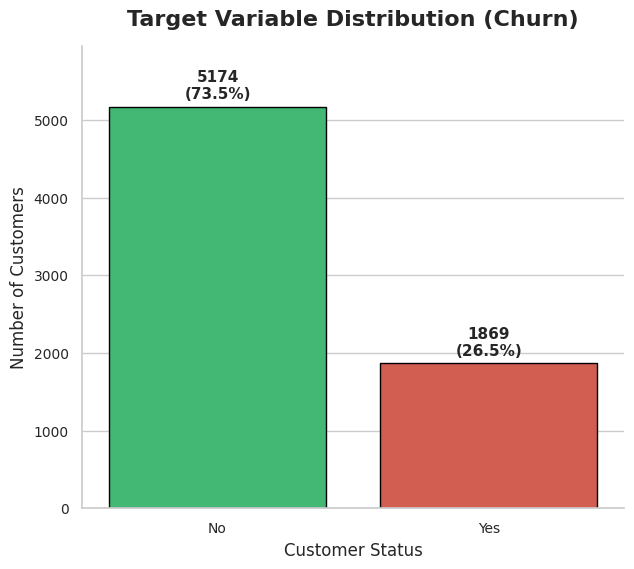

In [97]:
def plot_churn_distribution(df: pd.DataFrame, save_path: str = None) -> None:
    """
    Plot the distribution of the target variable (Churn).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset containing the target variable.
    save_path : str, optional
        Path to save the figure. If None, the figure is not saved.
    """
    plt.figure(figsize=(7, 6))

    counts = df["Churn"].value_counts()
    percentages = df["Churn"].value_counts(normalize=True) * 100

    ax = sns.barplot(
        x=counts.index,
        y=counts.values,
        palette=PALETTE_CHURN,
        edgecolor="black",
        linewidth=1
    )

    ax.set_title("Target Variable Distribution (Churn)", pad=15, fontweight="bold")
    ax.set_xlabel("Customer Status")
    ax.set_ylabel("Number of Customers")
    ax.set_ylim(0, counts.max() * 1.15)

    for i, bar in enumerate(ax.patches):
        label = f"{int(bar.get_height())}\n({percentages.iloc[i]:.1f}%)"
        ax.annotate(
            label,
            (bar.get_x() + bar.get_width() / 2, bar.get_height()),
            ha="center",
            va="center",
            xytext=(0, 15),
            textcoords="offset points",
            fontsize=11,
            fontweight="bold"
        )

    sns.despine()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


# Execution
save_path = "churn_distribution.png"
plot_churn_distribution(df, save_path=save_path)


The target variable exhibits a clear class imbalance, with churned customers representing a minority of the dataset.  
This imbalance must be explicitly addressed during model training and evaluation, prioritizing metrics such as Recall and ROC-AUC and considering resampling techniques to prevent bias toward the majority class.


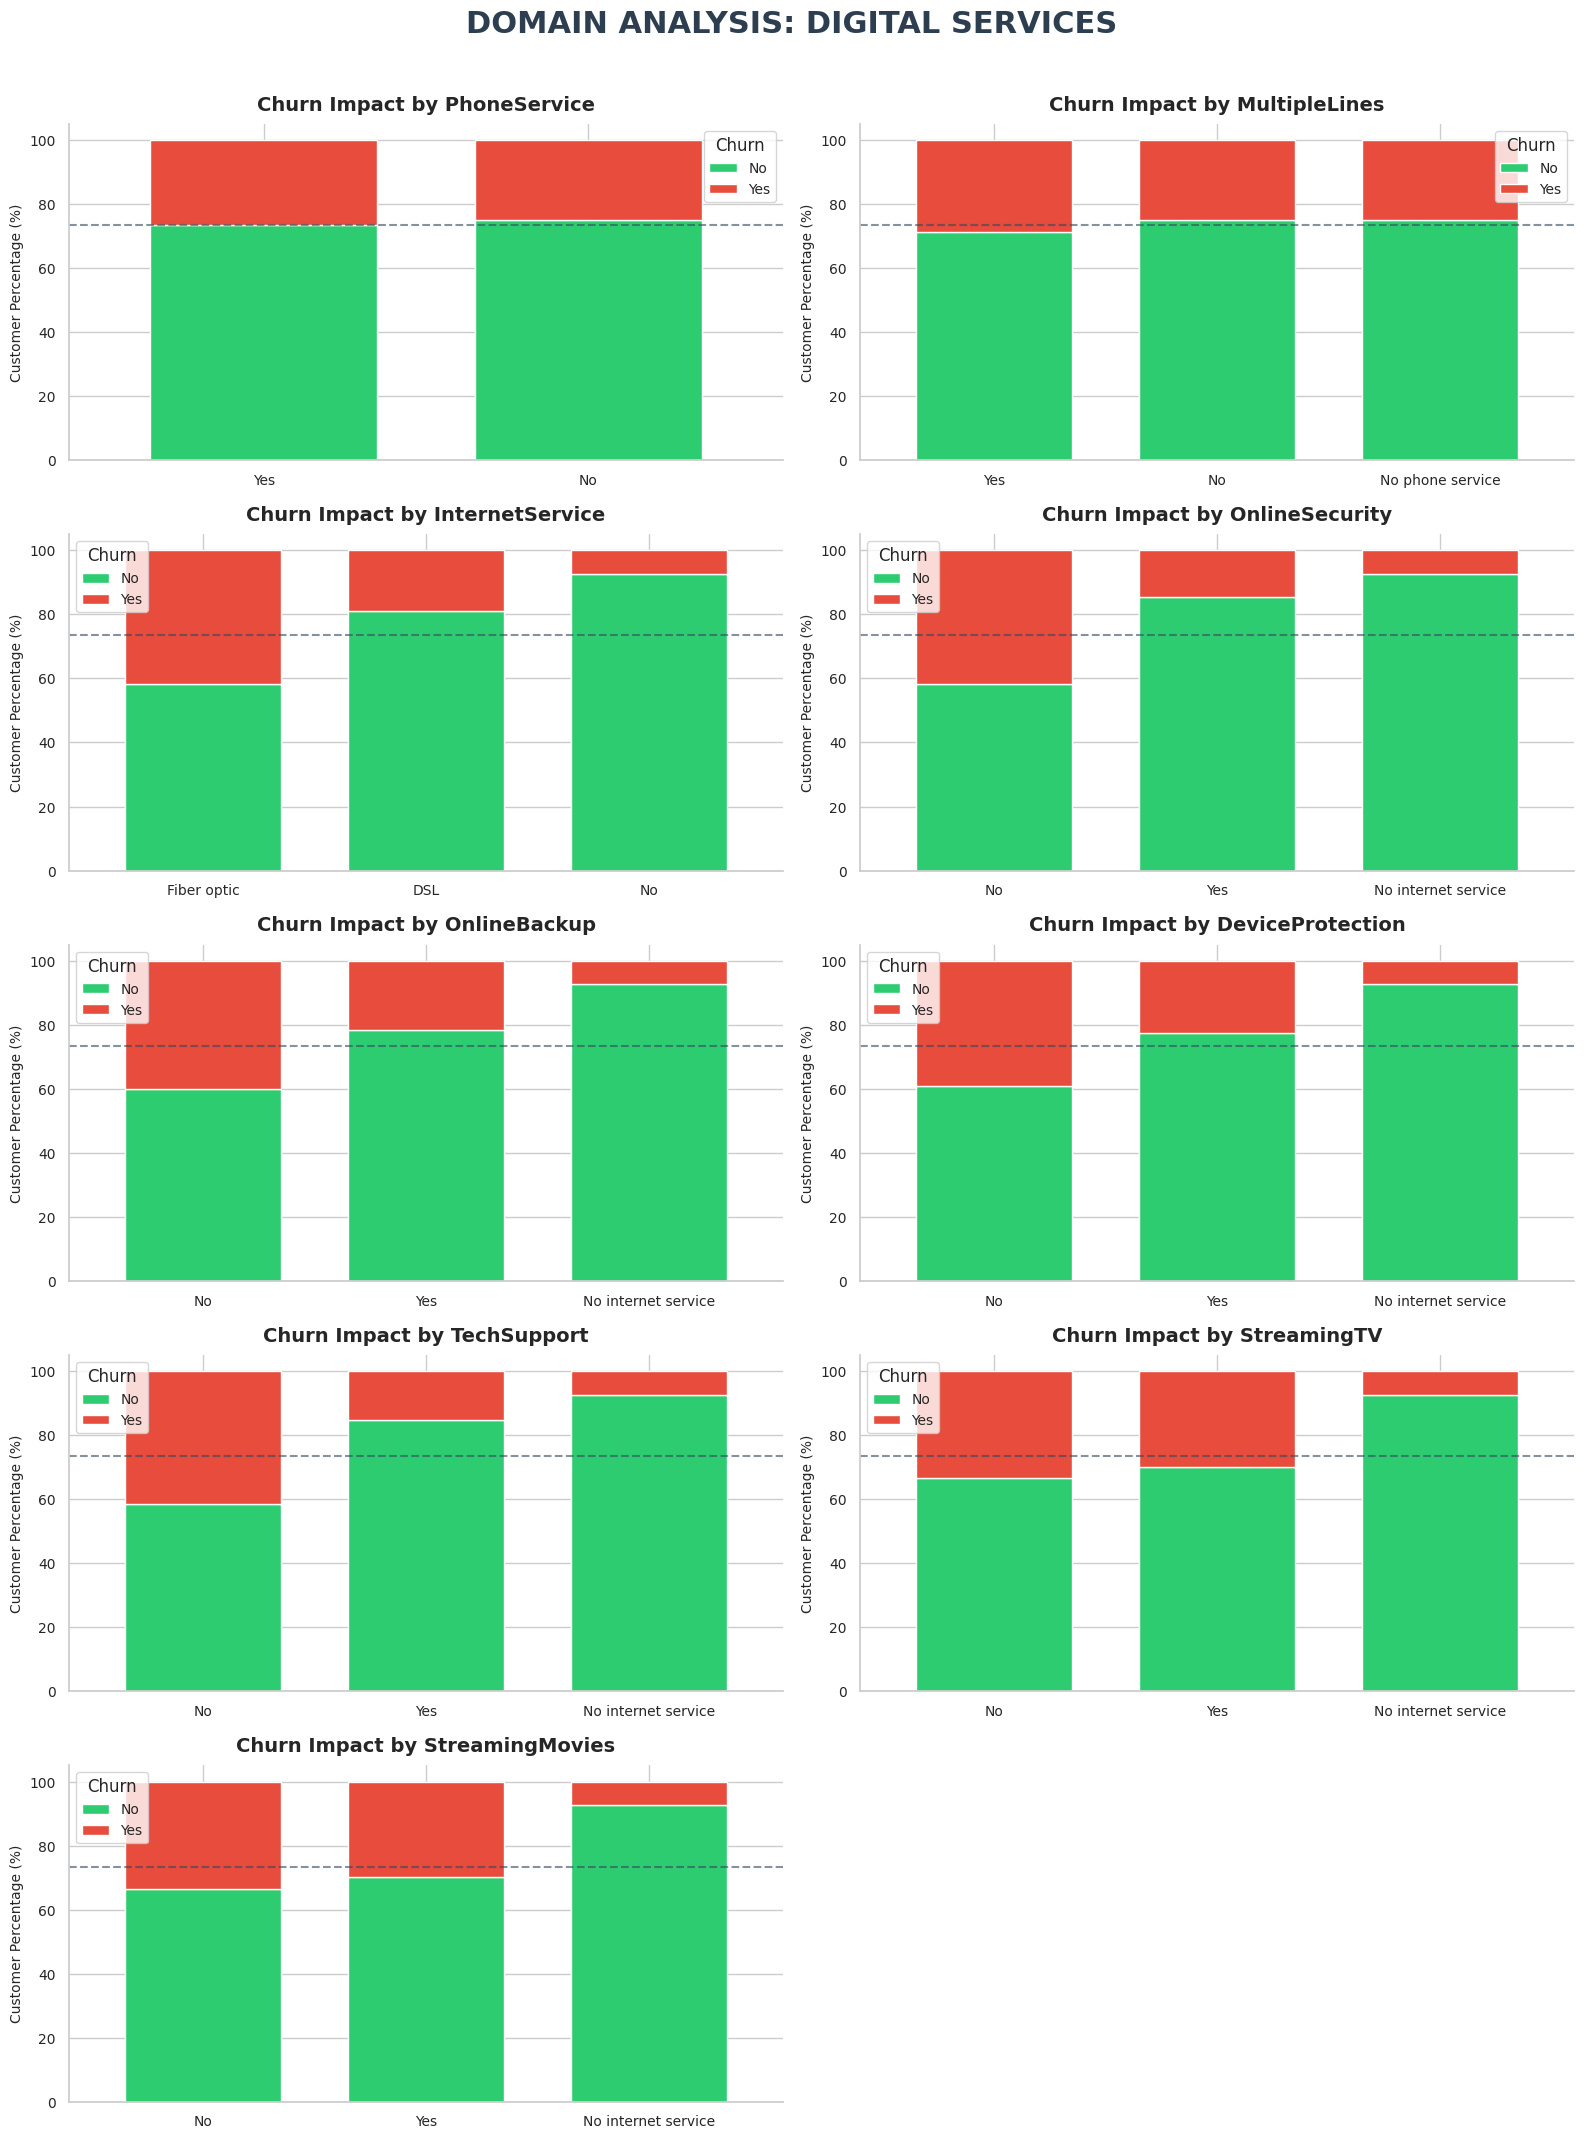

In [98]:
def analyze_all_categorical_churn_risks(
    df: pd.DataFrame,
    group_name: str,
    columns: list
):
    """
    Performs a comparative churn risk analysis for a group of categorical variables.

    This function generates stacked bar charts showing the percentage distribution
    of churn outcomes per category, highlighting segments with higher churn risk.
    A global churn baseline is included for executive-level comparison.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset containing customer information and a 'Churn' target column.
    group_name : str
        Logical name of the variable group being analyzed (used in the main title).
    columns : list
        List of categorical feature names to analyze.
    """

    n_cols = len(columns)
    n_rows = (n_cols + 1) // 2

    # Create subplot grid dynamically based on the number of variables
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, n_rows * 4.5))
    axes = axes.flatten()

    # Global churn rate used as a company-wide baseline reference
    global_churn_rate = (df['Churn'] == 'Yes').mean() * 100

    for i, col in enumerate(columns):


        # Data preparation: normalized churn proportions

        churn_distribution = (
            df.groupby(col)['Churn']
              .value_counts(normalize=True)
              .unstack(fill_value=0) * 100
        )

        # Sort categories by churn risk (Yes) to emphasize high-risk segments
        if 'Yes' in churn_distribution.columns:
            churn_distribution = churn_distribution.sort_values(
                by='Yes',
                ascending=False
            )


        # Visualization: stacked bar chart

        churn_distribution.plot(
            kind='bar',
            stacked=True,
            color=PALETTE_CHURN,
            ax=axes[i],
            width=0.7,
            edgecolor='white',
            linewidth=1
        )


        # Subplot styling and annotations

        axes[i].set_title(
            f"Churn Impact by {col}",
            fontsize=14,
            fontweight='bold',
            pad=10
        )
        axes[i].set_ylabel("Customer Percentage (%)", fontsize=10)
        axes[i].set_xlabel("")
        axes[i].tick_params(axis='x', rotation=0)

        # Global churn baseline reference
        axes[i].axhline(
            y=100 - global_churn_rate,
            color='#34495e',
            linestyle='--',
            alpha=0.6,
            label='Global Average'
        )

        # Remove unnecessary spines for a clean executive look
        sns.despine(ax=axes[i], left=False, bottom=False)

    # Remove unused subplots if the grid is not fully occupied
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Final layout adjustments
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(
        f"DOMAIN ANALYSIS: {group_name.upper()}",
        fontsize=22,
        fontweight='bold',
        color='#2c3e50'
    )
    plt.show()



# EXECUTION

digital_services_features = [
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

analyze_all_categorical_churn_risks(
    df=df,
    group_name="Digital Services",
    columns=digital_services_features
)


Service penetration analysis reveals that churn is not uniform; there are critical disparities in the value proposition across digital products:

- Fiber Optic Friction (Pain Point): Customers with Fiber Optic service exhibit the highest churn rate (nearly 40%). Despite being a superior technology, this segment is the primary detractor, suggesting technical stability issues or a perception of overpriced service compared to competitors.

- Sticky Services (Retention Anchors): Online Security, Tech Support, and Online Backup act as powerful retention anchors. Users with these services show drastically lower churn, establishing themselves as "safety features" that increase the customer's switching costs.

- Telephony Neutrality: Voice services (Phone Service and Multiple Lines) have zero impact on loyalty; their churn distribution is identical to the population average, defining them as commodities with no differentiating value in this dataset.

- Streaming Volatility: Content services (Streaming TV/Movies) show a slightly higher-than-average churn. These are perceived as "extra" or dispensable expenses that fail to compensate for a deficient core connectivity experience.

Strategic Insight

The success of this MVP relies on shifting the sales focus: instead of promoting raw connection speed (Fiber), marketing efforts should prioritize Security and Support Bundling to "shield" high-risk customers and improve overall Lifetime Value (LTV).

In [99]:
def analyze_financial_drivers(
    df: pd.DataFrame,
    save_path: str = None
) -> None:
    """
    Analyze key financial and account drivers of churn.
    """

    df_plot = df.copy()
    df_plot["TotalCharges"] = pd.to_numeric(
        df_plot["TotalCharges"], errors="coerce"
    ).fillna(0)

    fig, axes = plt.subplots(3, 2, figsize=(18, 20))
    axes = axes.flatten()

    global_churn_rate = (df_plot["Churn"] == "Yes").mean() * 100

    # Contract
    (
        df_plot.groupby("Contract")["Churn"]
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    ).plot(
        kind="bar",
        stacked=True,
        color=PALETTE_CHURN,
        ax=axes[0],
        edgecolor="black",
        linewidth=1
    )
    axes[0].set_title("Contract Type Impact", fontweight="bold")
    axes[0].tick_params(axis="x", rotation=0)

    # Paperless Billing
    (
        df_plot.groupby("PaperlessBilling")["Churn"]
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    ).plot(
        kind="bar",
        stacked=True,
        color=PALETTE_CHURN,
        ax=axes[1],
        edgecolor="black",
        linewidth=1
    )
    axes[1].set_title("Paperless Billing Impact", fontweight="bold")
    axes[1].tick_params(axis="x", rotation=0)

    # Payment Method
    (
        df_plot.groupby("PaymentMethod")["Churn"]
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    ).sort_values(
        by="Yes", ascending=True
    ).plot(
        kind="barh",
        stacked=True,
        color=PALETTE_CHURN,
        ax=axes[2],
        edgecolor="black",
        linewidth=1
    )
    axes[2].set_title("Churn Risk by Payment Method", fontweight="bold")

    # Tenure Distribution
    sns.kdeplot(
        data=df_plot,
        x="tenure",
        hue="Churn",
        palette=PALETTE_CHURN,
        fill=True,
        ax=axes[3]
    )
    axes[3].set_title("Tenure Distribution by Churn", fontweight="bold")

    # Monthly Charges
    sns.boxplot(
        x="Churn",
        y="MonthlyCharges",
        data=df_plot,
        palette=PALETTE_CHURN,
        ax=axes[4]
    )
    axes[4].set_title("Monthly Charges Sensitivity", fontweight="bold")

    # Tenure vs Total Charges
    sns.scatterplot(
        data=df_plot,
        x="tenure",
        y="TotalCharges",
        hue="Churn",
        palette=PALETTE_CHURN,
        alpha=0.4,
        s=30,
        ax=axes[5]
    )
    axes[5].set_title("Customer Lifetime Value vs Tenure", fontweight="bold")

    for i, ax in enumerate(axes):
        sns.despine(ax=ax)
        if i in [0, 1, 2]:
            ax.axhline(
                y=100 - global_churn_rate,
                color="#34495e",
                linestyle="--",
                alpha=0.5
            )

    plt.suptitle(
        "Financial & Account Drivers — Churn Diagnosis",
        fontsize=22,
        fontweight="bold",
        color="#2c3e50"
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


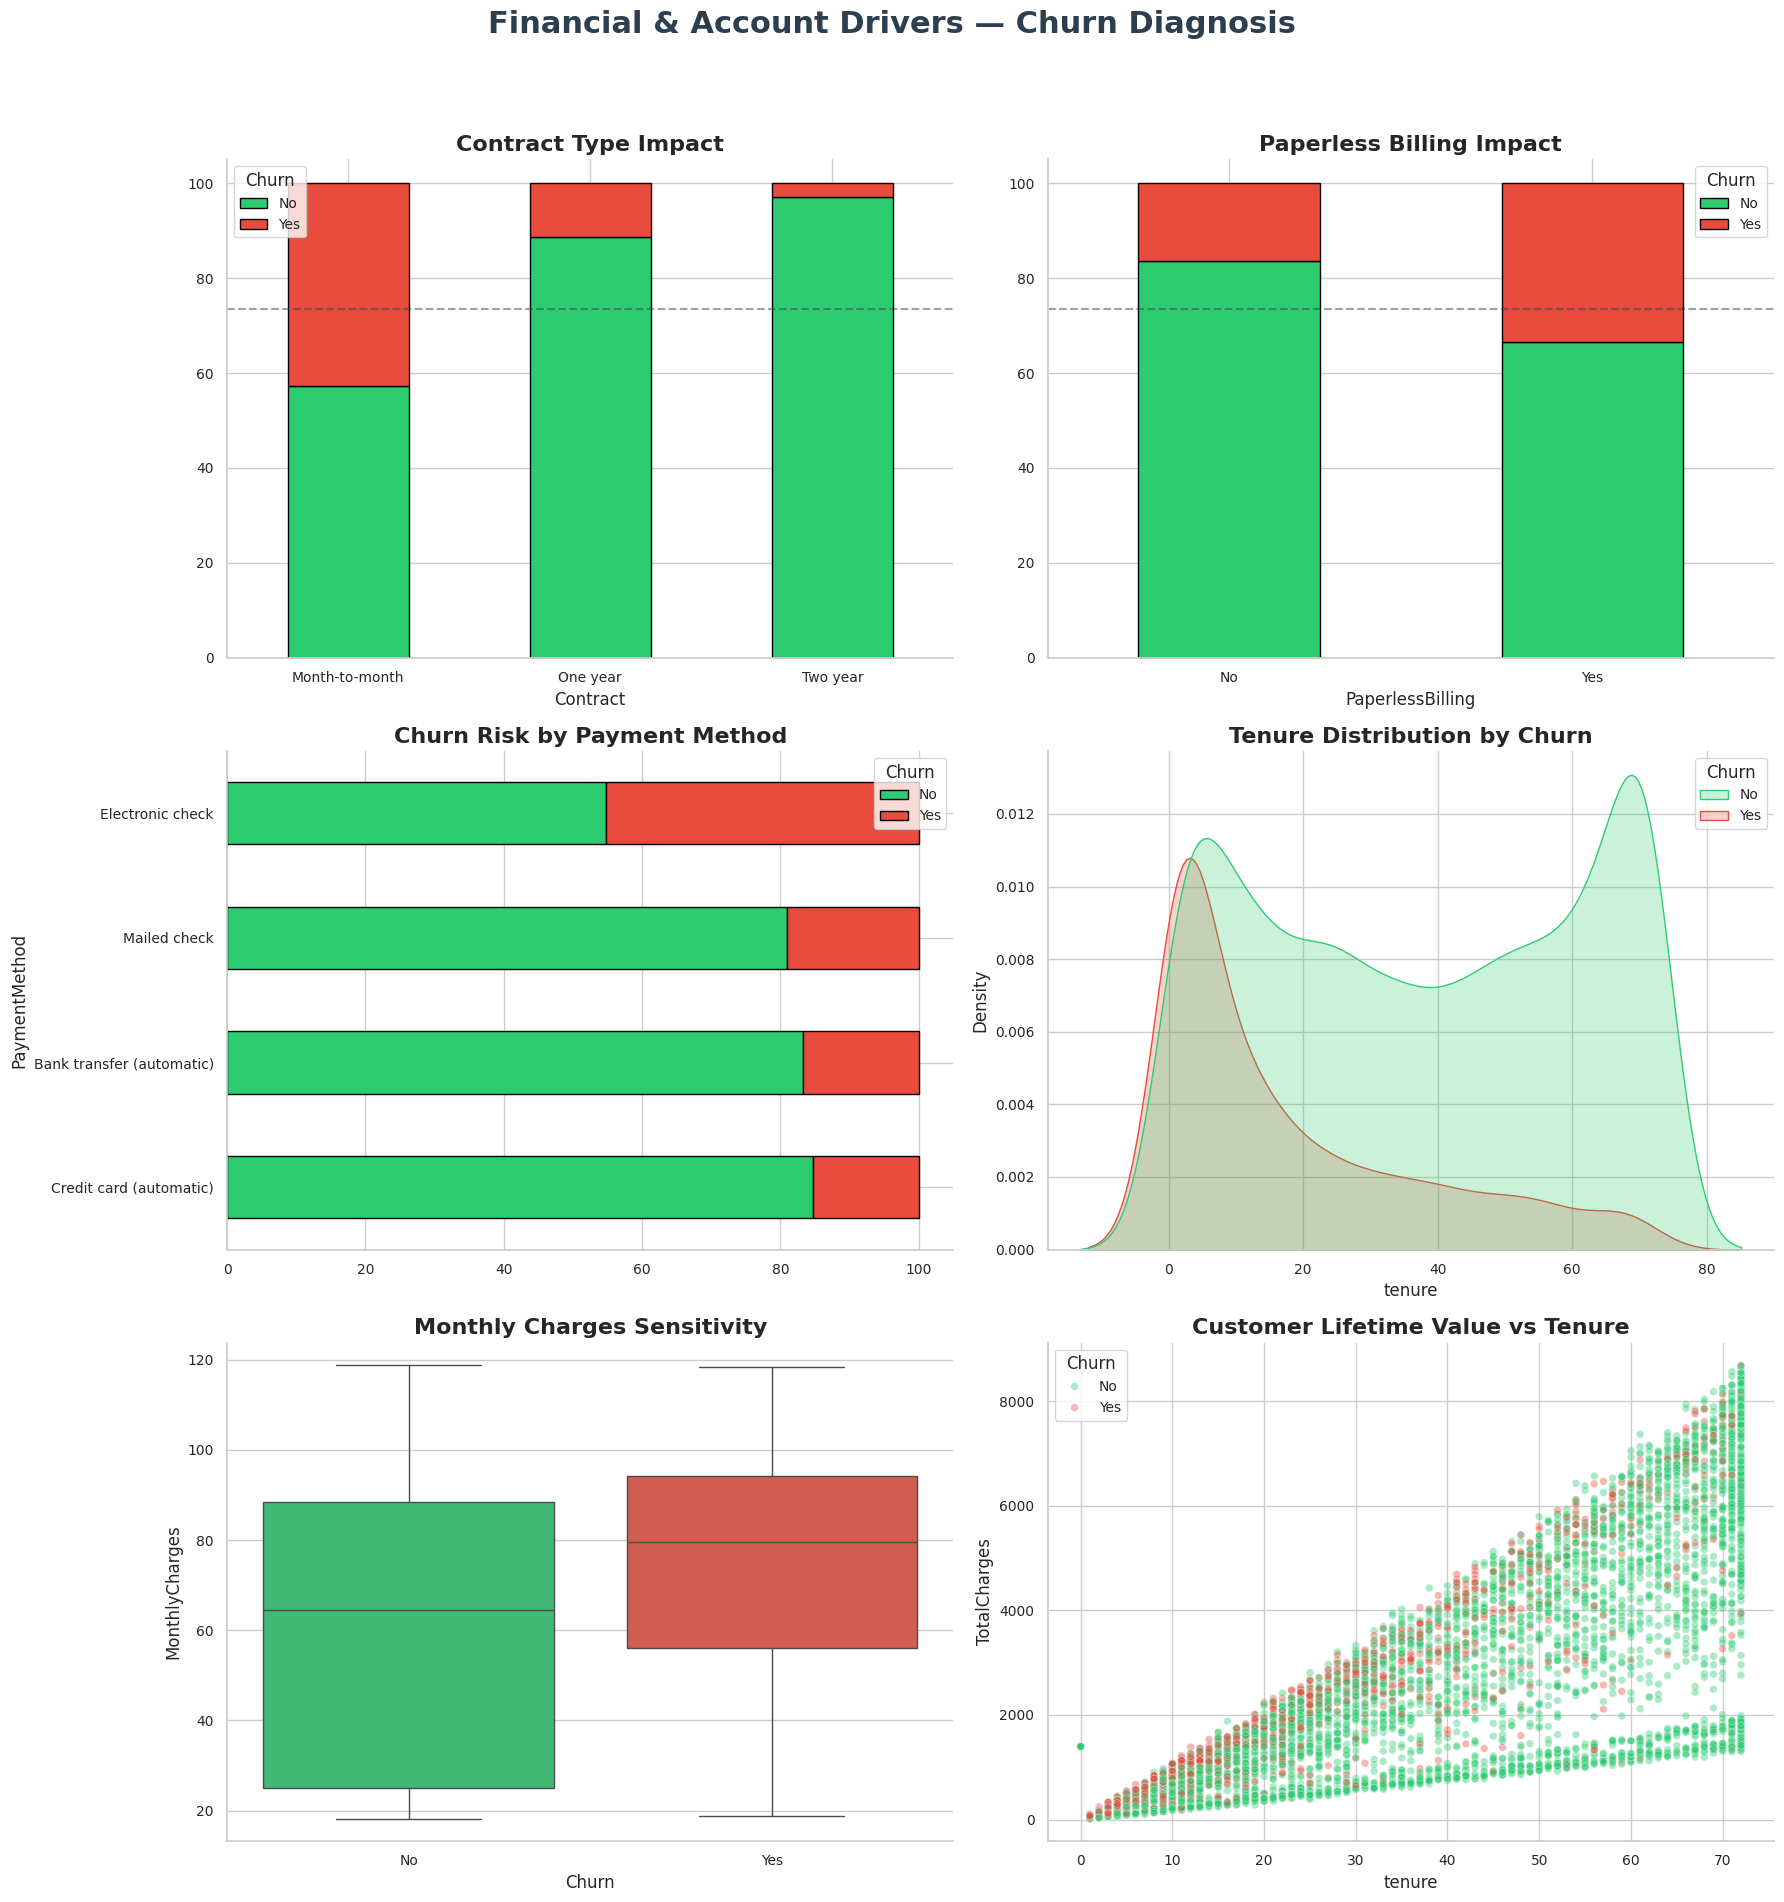

In [100]:
save_path = "financial_drivers_churn.png"

analyze_financial_drivers(
    df,
    save_path=save_path
)

**💳 Financial & Account Drivers: Churn Diagnosis**

Financial analysis identifies that churn is primarily driven by contract stability and spending thresholds:

- Contractual Vulnerability: Month-to-month contracts are the leading trigger for churn (~45% attrition rate). Stability increases drastically with two-year contracts, where risk is minimal.

- Payment Friction: Use of Electronic Checks strongly correlates with high churn. Automated methods (Credit Card/Bank Transfer) exhibit superior retention rates.

- Critical Tenure Zone: There is a peak in churn within the first 10 months. Surpassing the 20-month mark exponentially reduces the probability of abandonment.

- Price Sensitivity: Customers who churn have a higher median monthly charge (~$80), confirming that cost is a critical barrier to long-term retention.

💡 Strategic Insight

The business recommendation is to implement "Financial Shielding": incentivizing automated payments and offering loyalty bonuses before the 6-month mark to mitigate early-stage attrition.

In [101]:
def analyze_demographic_risk(
    df: pd.DataFrame,
    save_path: str = None
) -> None:
    """
    Analyze demographic and social attachment drivers of churn.
    """

    demographic_features = ["gender", "SeniorCitizen", "Partner", "Dependents"]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    global_churn_rate = (df["Churn"] == "Yes").mean() * 100

    for i, feature in enumerate(demographic_features):

        churn_pct = (
            df.groupby(feature)["Churn"]
              .value_counts(normalize=True)
              .unstack(fill_value=0) * 100
        )

        churn_pct.plot(
            kind="bar",
            stacked=True,
            color=PALETTE_CHURN,
            ax=axes[i],
            edgecolor="black",
            linewidth=1,
            width=0.6
        )

        axes[i].set_title(feature, fontweight="bold", pad=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Percentage of Customers")
        axes[i].tick_params(axis="x", rotation=0)

        axes[i].axhline(
            y=100 - global_churn_rate,
            color="#34495e",
            linestyle="--",
            alpha=0.7
        )

        sns.despine(ax=axes[i])

    plt.suptitle(
        "Demographic Profile & Social Attachment — Churn Analysis",
        fontsize=22,
        fontweight="bold",
        color="#2c3e50"
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


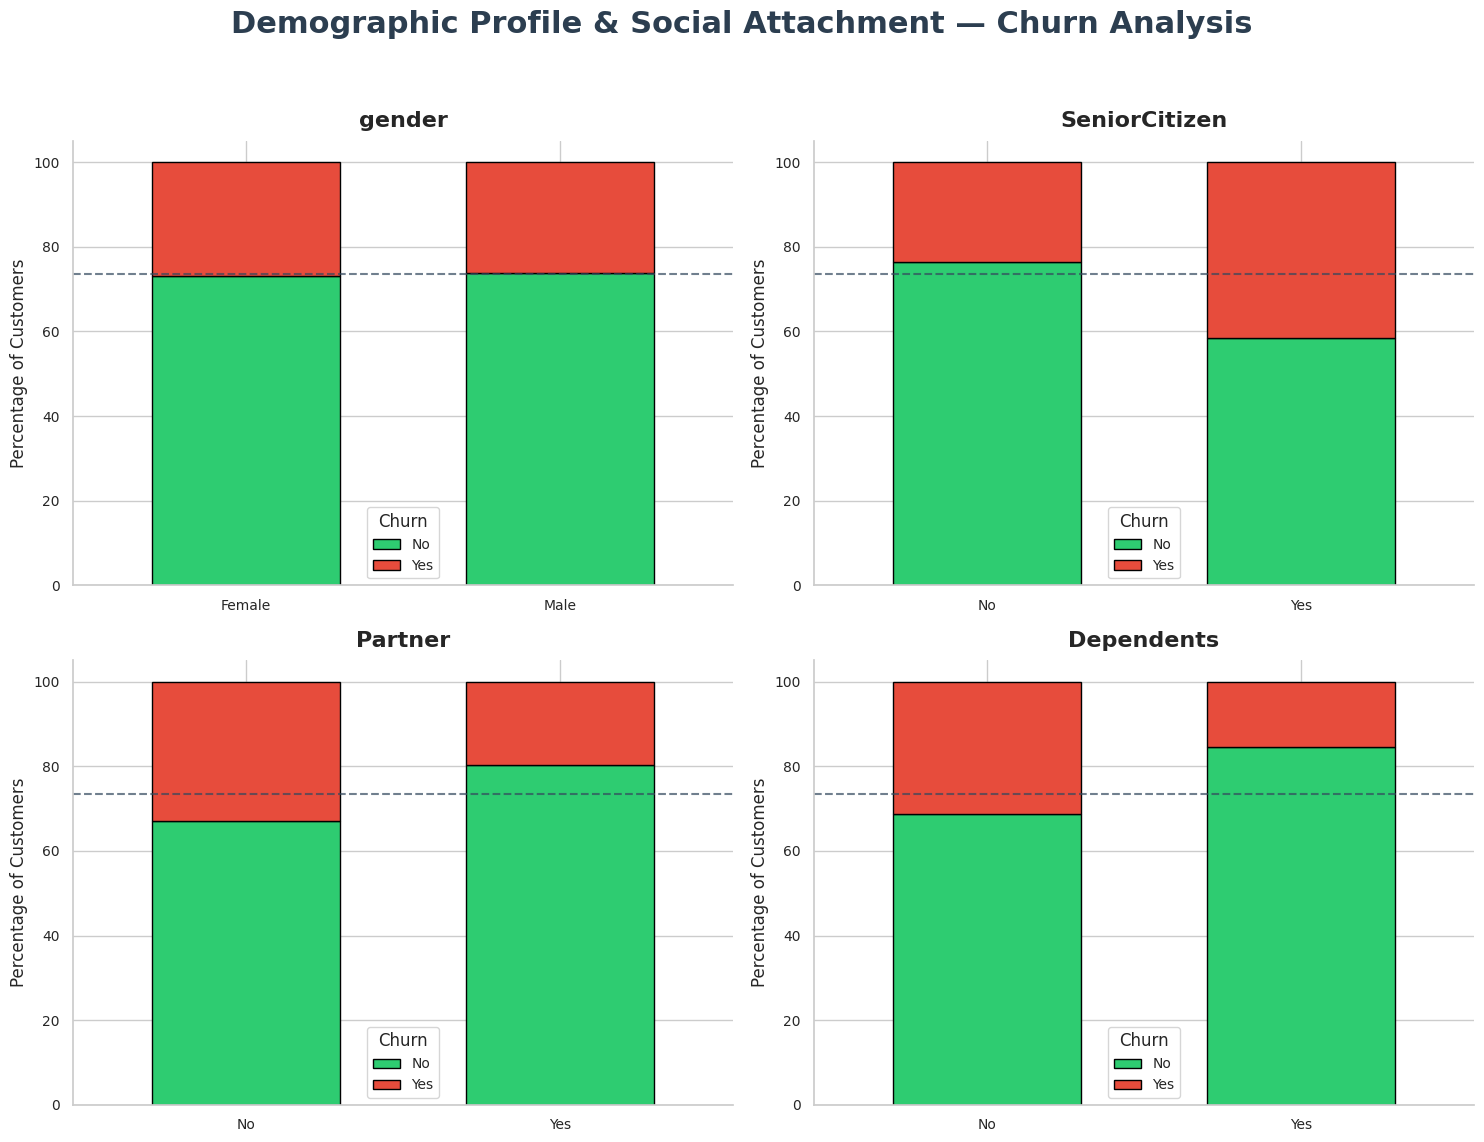

In [102]:
save_path = "demographic_risk_churn.png"
analyze_demographic_risk(
    df,
    save_path=save_path
)

The demographic profile helps identify the most socially vulnerable segments regarding retention:

- Social Attachment Effect: Customers with a Partner or Dependents exhibit a significantly lower churn rate. "Social attachment" and family-linked accounts act as stabilizers for the commercial relationship.

- Senior Citizens: Older adults show a higher attrition rate compared to the general population. This segment may require more personalized support channels or specific service plans tailored to their consumption patterns.

- Gender Neutrality: The Gender variable shows no correlation with churn, allowing the exclusion of gender bias from marketing and retention strategies.

## **4. Exploratory cleaning**

In [103]:
def exploratory_cleaning_pipeline(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Perform core data cleaning for the experimentation phase.
    """

    df_clean = df.copy()

    if "customerID" in df_clean.columns:
        df_clean.drop(columns="customerID", inplace=True)
        print("-> customerID column removed.")

    df_clean["TotalCharges"] = pd.to_numeric(
        df_clean["TotalCharges"], errors="coerce"
    )

    missing_total = df_clean["TotalCharges"].isna().sum()
    if missing_total > 0:
        df_clean["TotalCharges"].fillna(0, inplace=True)
        print(f"-> {missing_total} missing values in TotalCharges imputed with 0.")

    categorical_fix = [
        "MultipleLines",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies"
    ]

    for col in categorical_fix:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].replace({
                "No internet service": "No",
                "No phone service": "No"
            })

    print(f"-> Category normalization applied to {len(categorical_fix)} features.")

    if "SeniorCitizen" in df_clean.columns:
        df_clean["SeniorCitizen"] = df_clean["SeniorCitizen"].replace({
            1: "Yes",
            0: "No"
        })

    return df_clean




In [104]:
df_exp = exploratory_cleaning_pipeline(df)

print("\n--- POST-CLEANING DATA SUMMARY ---")
df_exp.info()


-> Category normalization applied to 7 features.

--- POST-CLEANING DATA SUMMARY ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  Pape

## **5. Feature Engineering (exploratory)**

In [105]:
def exploratory_feature_engineering(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Create business-driven features to enhance churn detection.
    """

    df_fe = df.copy()

    df_fe["tenure_group"] = pd.cut(
        df_fe["tenure"],
        bins=[0, 12, 24, 48, 100],
        labels=["Newborn", "Junior", "Senior", "Loyal"],
        include_lowest=True
    )

    service_features = [
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies"
    ]

    df_fe["services_count"] = (
        df_fe[service_features] == "Yes"
    ).sum(axis=1)

    df_fe["billing_ratio"] = np.where(
        df_fe["TotalCharges"] > 0,
        df_fe["MonthlyCharges"] / df_fe["TotalCharges"],
        0
    )

    print(
        "-> Features created: tenure_group, services_count, billing_ratio"
    )

    return df_fe





In [106]:
# Execution
df_final_exp = exploratory_feature_engineering(df_exp)

-> Features created: tenure_group, services_count, billing_ratio


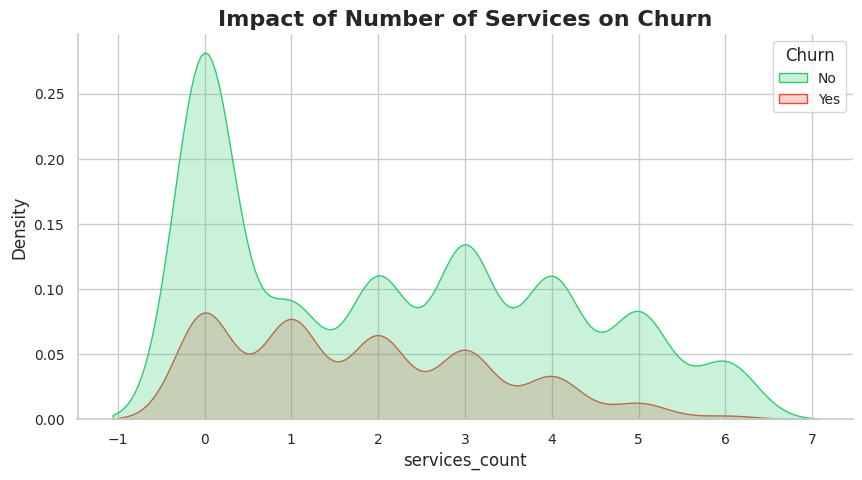

In [107]:
# Vizualization
plt.figure(figsize=(10, 5))

sns.kdeplot(
    data=df_final_exp,
    x="services_count",
    hue="Churn",
    fill=True,
    palette=PALETTE_CHURN
)

plt.title(
    "Impact of Number of Services on Churn",
    fontweight="bold"
)

sns.despine()
plt.show()


In [108]:
df_final_exp

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,services_count,billing_ratio
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Newborn,1,1.000000
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,One year,No,Mailed check,56.95,1889.50,No,Senior,2,0.030140
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Newborn,2,0.497920
3,Male,No,No,No,45,No,No,DSL,Yes,No,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Senior,3,0.022980
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Newborn,0,0.466205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,One year,Yes,Mailed check,84.80,1990.50,No,Junior,5,0.042602
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,Loyal,4,0.014016
7040,Female,No,Yes,Yes,11,No,No,DSL,Yes,No,...,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,Newborn,1,0.085438
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,Newborn,0,0.242661


##**6. Controlled experimentation**







Definition of functions


In [109]:
# Data Matrix Preparation (Stratified Split)
def prepare_train_test(
    df: pd.DataFrame,
    target: str = "Churn",
    test_size: float = 0.20,
    random_state: int = 42,
    verbose: bool = True
):
    """
    Prepare X and y and perform a stratified train-test split.
    Use ONLY during the experimentation phase (Section A).
    """

    if target not in df.columns:
        raise ValueError(f"Target column '{target}' does not exist")

    # Clean and validated target
    y_raw = df[target].astype(str).str.strip()

    if not set(y_raw.unique()).issubset({"Yes", "No"}):
        raise ValueError(
            f"Unexpected values found in '{target}': {y_raw.unique()}"
        )

    y = y_raw.map({"Yes": 1, "No": 0})
    X = df.drop(columns=[target])

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    if verbose:
        print("— Stratified Split Completed —")
        print(f"Train size: {X_train.shape[0]}")
        print(f"Test size : {X_test.shape[0]}")
        print(f"Churn rate (test): {y_test.mean():.2%}")

    return X_train, X_test, y_train, y_test


In [110]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


def build_preprocessor(
    X: pd.DataFrame,
    scale_numeric: bool = True
) -> ColumnTransformer:
    """
    Build a column-wise preprocessing pipeline.

    Parameters
    ----------
    X : pd.DataFrame
        Input feature matrix.
    scale_numeric : bool
        - True  → apply scaling to numerical features
        - False → leave numerical features unchanged
    """

    num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    num_transformer = RobustScaler() if scale_numeric else "passthrough"

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_cols),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
        ]
    )

    return preprocessor


In [111]:
# Pipeline construction (standard or balanced)
def build_pipeline(
    model,
    preprocessor,
    use_smote: bool = False,
    random_state: int = 42
):
    """
    Build a pipeline with or without SMOTE.
    """

    if use_smote:
        pipe = ImbPipeline(steps=[
            ("preprocessor", preprocessor),
            ("smote", SMOTE(random_state=random_state)),
            ("classifier", model)
        ])
    else:
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])

    return pipe


In [112]:
# Unified evaluation function (metrics only)
def evaluate_model(pipe, X_test, y_test):
    """
    Evaluate a trained model and return key performance metrics.
    """

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    return {
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba)
    }


In [113]:
# FUNCTION FOR CONTROLLED EXPERIMENTATION

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def run_experiments(X_train, X_test, y_train, y_test):

    experiments = [
        {
            "model_name": "LogReg",
            "model": LogisticRegression(max_iter=1000, random_state=42),
            "scale": False,
            "smote": False
        },
        {
            "model_name": "LogReg",
            "model": LogisticRegression(max_iter=1000, random_state=42),
            "scale": True,
            "smote": True
        },
        {
            "model_name": "RF",
            "model": RandomForestClassifier(random_state=42),
            "scale": False,
            "smote": False
        },
        {
            "model_name": "RF",
            "model": RandomForestClassifier(random_state=42),
            "scale": False,
            "smote": True
        }
    ]

    results = []

    for exp in experiments:
        preprocessor = build_preprocessor(
            X_train,
            scale_numeric=exp["scale"]
        )

        pipe = build_pipeline(
            model=exp["model"],
            preprocessor=preprocessor,
            use_smote=exp["smote"]
        )

        pipe.fit(X_train, y_train)

        metrics = evaluate_model(pipe, X_test, y_test)

        results.append({
            "Model": exp["model_name"],
            "Scaling": exp["scale"],
            "SMOTE": exp["smote"],
            **metrics
        })

    return pd.DataFrame(results).sort_values("Recall", ascending=False)


**Base dataset (without feature engineering)**

In [114]:
# Base dataset for experimentation
df_base = df_exp.copy()


**Stratified split**

This is done only once per dataset.


In [115]:
X_train, X_test, y_train, y_test = prepare_train_test(
    df=df_base,
    target='Churn'
)


— Stratified Split Completed —
Train size: 5634
Test size : 1409
Churn rate (test): 26.54%


The split does NOT go inside run_experiments
because control and reproducibility would be lost.

**Conduct controlled experimentation**

In [116]:
results_base = run_experiments(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

results_base


,Model,Scaling,SMOTE,Precision,Recall,F1,ROC_AUC
1,LogReg,True,True,0.505102,0.794118,0.617464,0.840094
0,LogReg,False,False,0.656151,0.556150,0.602026,0.842561
3,RF,False,True,0.614887,0.508021,0.556369,0.823358
2,RF,False,False,0.626298,0.483957,0.546003,0.824461


Preliminary observations:
- Logistic Regression improves Recall with SMOTE + scaling, but loses Precision.
- Random Forest shows greater stability without scaling.
- SMOTE in RF marginally increases Recall, with a slight impact on Precision.


**EXPERIMENTING WITH FEATURE ENGINEERING**

Now we repeat EXACTLY the same protocol,
changing only one thing: the dataset.

In [117]:
df_fe = exploratory_feature_engineering(df_exp)


-> Features created: tenure_group, services_count, billing_ratio


Stratified split (again)



In [118]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = prepare_train_test(
    df=df_fe,
    target='Churn'
)


— Stratified Split Completed —
Train size: 5634
Test size : 1409
Churn rate (test): 26.54%


The same experiments are performed.

In [119]:
results_fe = run_experiments(
    X_train=X_train_fe,
    X_test=X_test_fe,
    y_train=y_train_fe,
    y_test=y_test_fe
)

results_fe


,Model,Scaling,SMOTE,Precision,Recall,F1,ROC_AUC
1,LogReg,True,True,0.503390,0.794118,0.616183,0.845966
0,LogReg,False,False,0.667785,0.532086,0.592262,0.849056
3,RF,False,True,0.613707,0.526738,0.566906,0.826429
2,RF,False,False,0.615646,0.483957,0.541916,0.822763


**Consolidation of results**

Final comparative table:

In [120]:
results_base["Feature_Engineering"] = "No"
results_fe["Feature_Engineering"] = "Yes"

results_all = pd.concat(
    [results_base, results_fe],
    ignore_index=True
).sort_values("Recall", ascending=False)

results_all


,Model,Scaling,SMOTE,Precision,Recall,F1,ROC_AUC,Feature_Engineering
0,LogReg,True,True,0.505102,0.794118,0.617464,0.840094,No
4,LogReg,True,True,0.503390,0.794118,0.616183,0.845966,Yes
1,LogReg,False,False,0.656151,0.556150,0.602026,0.842561,No
5,LogReg,False,False,0.667785,0.532086,0.592262,0.849056,Yes
6,RF,False,True,0.613707,0.526738,0.566906,0.826429,Yes
2,RF,False,True,0.614887,0.508021,0.556369,0.823358,No
3,RF,False,False,0.626298,0.483957,0.546003,0.824461,No
7,RF,False,False,0.615646,0.483957,0.541916,0.822763,Yes


**Conclusion of the controlled experiment:**

Logistic Regression combined with scaling and SMOTE offers the best performance in terms of Recall, fulfilling the main objective of the project: to detect as many customers at risk of churn as possible.

Random Forest presents a more conservative behavior, with less sensitivity to churn and little benefit from balancing.

The proposed feature engineering does not introduce noise and slightly improves the model's discriminatory capacity, justifying its use in the following stages.

Based on these results, Logistic Regression with SMOTE and scaling is selected as the main candidate for optimization and fine-tuning.

**Model selected for tuning**

WINNING MODEL

Logistic Regression + Scaling + SMOTE

Reason:

- Highest recall (~79%)

- Stable model

- Interpretability

- Easy deployment

- Excellent for threshold tuning

##**7. Hyperparameter Tuning**

**Hyperparameter Optimization Strategy**

**Objective**  
Improve Recall and F1-score while preserving model stability and avoiding overfitting.

**Search Strategy**  
**RandomizedSearchCV** is selected due to:
- Lower computational cost compared to exhaustive grid search
- Sufficient exploration for linear and tree-based models
- Better alignment with real-world production constraints

**Cross-Validation Scheme**
- StratifiedKFold
- 5 folds
- Shuffle enabled

**Optimization Metric**
- Primary: Recall (`scoring='recall'`)
- Alternative: `recall_weighted` (to account for class imbalance)


**Tuning**

In [121]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform

# 1. Preprocessor (WITHOUT feature engineering)
preprocessor = build_preprocessor(
    X_train,
    scale_numeric=True
)

# 2. Final pipeline with SMOTE
pipe = build_pipeline(
    model=LogisticRegression(max_iter=1000, random_state=42),
    preprocessor=preprocessor,
    use_smote=True
)

# 3. Hyperparameter search space
param_dist = {
    "classifier__C": loguniform(0.001, 10),
    "classifier__penalty": ["l2"],
    "classifier__solver": ["liblinear", "lbfgs"]
}

# 4. Stratified cross-validation
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# 5. Randomized Search
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 6. Training
search.fit(X_train, y_train)

# 7. Best model
best_model = search.best_estimator_

print("Best hyperparameters:")
print(search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:
{'classifier__C': np.float64(7.8527554947242555), 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


Before vs. After Comparison

In [122]:
# Baseline Evaluation (WITHOUT hyperparameter tuning)
pipe.fit(X_train, y_train)
baseline_metrics = evaluate_model(pipe, X_test, y_test)

# Tuned Model Evaluation
tuned_metrics = evaluate_model(best_model, X_test, y_test)

# Final Comparison
comparison = pd.DataFrame(
    [baseline_metrics, tuned_metrics],
    index=["Baseline", "Tuned"]
)

comparison


,Precision,Recall,F1,ROC_AUC
Baseline,0.505102,0.794118,0.617464,0.840094
Tuned,0.505085,0.796791,0.618257,0.839642


**Model Evaluation Summary**

Hyperparameter tuning via stratified cross-validation yielded **minimal improvement** over the baseline model:

- **Recall:** 0.794 → 0.797 (+0.3%)  
- **Precision:** ~0.505 (no significant change)  
- **F1-score:** +0.0008 (negligible)  
- **ROC-AUC:** ~0.84 (stable)

**Conclusion:**  
The baseline model already performs near its optimum for this feature set and the business objective of **maximizing Recall**. Tuning confirms its robustness but does not justify a


## **8. Final Model Decision**

### Selected Model
After controlled experimentation and hyperparameter tuning, the **final model** is:

**Logistic Regression + Numeric Scaling + SMOTE (training only)**

This model achieves the best balance of **performance, stability, and production readiness**.

---

### Technical Justification
- Highest consistent **Recall (~0.79)**, the key metric for churn detection.
- **ROC-AUC (~0.84)** demonstrates strong discrimination between churned and retained customers.
- Hyperparameter tuning showed **no significant improvement**, confirming baseline robustness.
- Logistic Regression provides:
  - Stability with noisy data
  - Scalable training and inference
  - Direct interpretability of coefficients

---

### Business Justification
- Goal: **minimize false negatives** (undetected churned customers)
- High Recall enables:
  - Early retention campaigns
  - Reduction of recurring revenue loss
- Slight reduction in Precision is acceptable because:
  - Cost of contacting additional customers is low
  - Cost of losing a customer is high

---

### Adopted Techniques
- **Robust scaling** for numerical features
- **SMOTE applied only during training**
- **End-to-end pipeline** to prevent data leakage
- **Stratified validation** to preserve real imbalance (~80/20)

---

### Discarded Techniques
- **Exploratory feature engineering**  
  - Marginal improvements  
  - Not aligned with backend data contract
- **Random Forest**  
  - Lower Recall  
  - Higher complexity, less interpretability
- **Aggressive hyperparameter tuning**  
  - No meaningful metric improvement  
  - Increases complexity without clear benefit

---

### Known Risks
- **Moderate Precision (~0.50)**  
  - Some false positives expected  
  - Mitigatable via threshold adjustment and business rules
- **Data drift**  
  - Requires periodic monitoring
- **Threshold dependency**  
  - Addressed explicitly in the next section

---

### Conclusion
The selected model **maximizes business impact**, maintains **operational simplicity**, and meets **production standards**, making it suitable for deployment in a real-world telecommunications environment.


## **9. Decision Threshold Optimization**

### What is a threshold?
Binary classification models predict a **probability** of belonging to the positive class, not a class directly.

In this project:
- Model output: `P(Churn = 1)`  
- Threshold defines the probability above which a customer is classified as **churned**

By default:
- `threshold = 0.50`  
- If `P(churn) ≥ 0.50` → Churn  
- If `P(churn) < 0.50` → No Churn

⚠️ Default threshold is **not optimal** for:
- Imbalanced classes
- Asymmetric error costs (FN ≫ FP)


### 9.1 Business Context (Telecom)
**Potential errors:**
- **False Negative (FN):** customer churns but is not detected → direct revenue loss + future acquisition cost  
- **False Positive (FP):** customer does not churn but is flagged → low operational cost (call, email, offer)

📌 In telecom:  
**FN is far more costly than FP**, so the threshold should **prioritize Recall over Accuracy**.

In [123]:
# Metrics calculation by threshold

# Probabilities from the final model
y_proba = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.10, 0.90, 0.05)

results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)

    results.append({
        "Threshold": t,
        "Precision": precision_score(y_test, y_pred_t),
        "Recall": recall_score(y_test, y_pred_t),
        "F1": f1_score(y_test, y_pred_t)
    })

threshold_df = pd.DataFrame(results)
threshold_df


,Threshold,Precision,Recall,F1
0,0.10,0.350095,0.986631,0.516807
1,0.15,0.372569,0.973262,0.538860
2,0.20,0.397124,0.959893,0.561815
3,0.25,0.413507,0.933155,0.573071
4,0.30,0.433249,0.919786,0.589041
5,0.35,0.448871,0.903743,0.599823
6,0.40,0.465909,0.877005,0.608534
7,0.45,0.485938,0.831551,0.613412
8,0.50,0.505085,0.796791,0.618257
9,0.55,0.521739,0.737968,0.611296


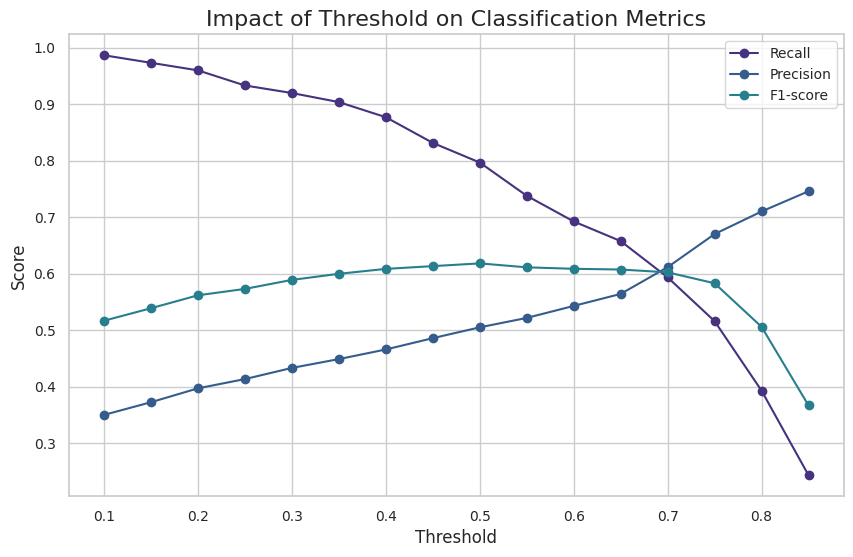

In [124]:
# Visualization of Precision vs Recall Trade-off

plt.figure(figsize=(10,6))
plt.plot(threshold_df["Threshold"], threshold_df["Recall"], label="Recall", marker="o")
plt.plot(threshold_df["Threshold"], threshold_df["Precision"], label="Precision", marker="o")
plt.plot(threshold_df["Threshold"], threshold_df["F1"], label="F1-score", marker="o")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Impact of Threshold on Classification Metrics")
plt.legend()
plt.grid(True)
plt.show()



### 9.2 Simple Business Cost Simulation

Conservative assumption:
- FN cost = 5
- FP cost = 1

(The ratio matters more than the absolute value)


In [125]:
from sklearn.metrics import confusion_matrix

cost_fn = 5
cost_fp = 1

cost_results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    total_cost = fn * cost_fn + fp * cost_fp

    cost_results.append({
        "Threshold": t,
        "False Negatives": fn,
        "False Positives": fp,
        "Total Cost": total_cost
    })

cost_df = pd.DataFrame(cost_results)
cost_df.sort_values("Total Cost")


,Threshold,False Negatives,False Positives,Total Cost
5,0.35,36,415,595
4,0.30,30,450,600
6,0.40,46,376,606
3,0.25,25,495,620
2,0.20,15,545,620
7,0.45,63,329,644
1,0.15,10,613,663
8,0.50,76,292,672
0,0.10,5,685,710
9,0.55,98,253,743


In [126]:
# Selection of the Operating Threshold
optimal_threshold = cost_df.sort_values("Total Cost").iloc[0]["Threshold"]
optimal_threshold


np.float64(0.3500000000000001)

**Operational Threshold Selection**

**Selected threshold:** 0.35

Business Justification
- Minimizes total business cost (FN >> FP)
- Reduces False Negatives while keeping Recall high (~90%)
- Accepts more False Positives, aligned with retention strategies

This threshold will be applied in production for inference.


## **10. Final Model Interpretability**

**Selected Model:** Logistic Regression  
**Objective:** Identify the main churn drivers and translate them into actionable business rules.


In [127]:
# Extract feature names after preprocessing
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

# Extract model coefficients
coefficients = best_model.named_steps["classifier"].coef_[0]

# Create a DataFrame with features and their coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Calculate absolute impact for sorting
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()

# Select top 10 drivers by absolute impact
top_drivers = coef_df.sort_values(
    "Abs_Coefficient",
    ascending=False
).head(10)

top_drivers


,Feature,Coefficient,Abs_Coefficient
0,num__tenure,-2.487120,2.487120
1,num__MonthlyCharges,-2.129664,2.129664
10,cat__InternetService_No,-1.704080,1.704080
9,cat__InternetService_Fiber optic,1.680997,1.680997
18,cat__Contract_Two year,-1.534902,1.534902
2,num__TotalCharges,1.077794,1.077794
17,cat__Contract_One year,-0.801234,0.801234
16,cat__StreamingMovies_Yes,0.690361,0.690361
15,cat__StreamingTV_Yes,0.560561,0.560561
8,cat__MultipleLines_Yes,0.466510,0.466510


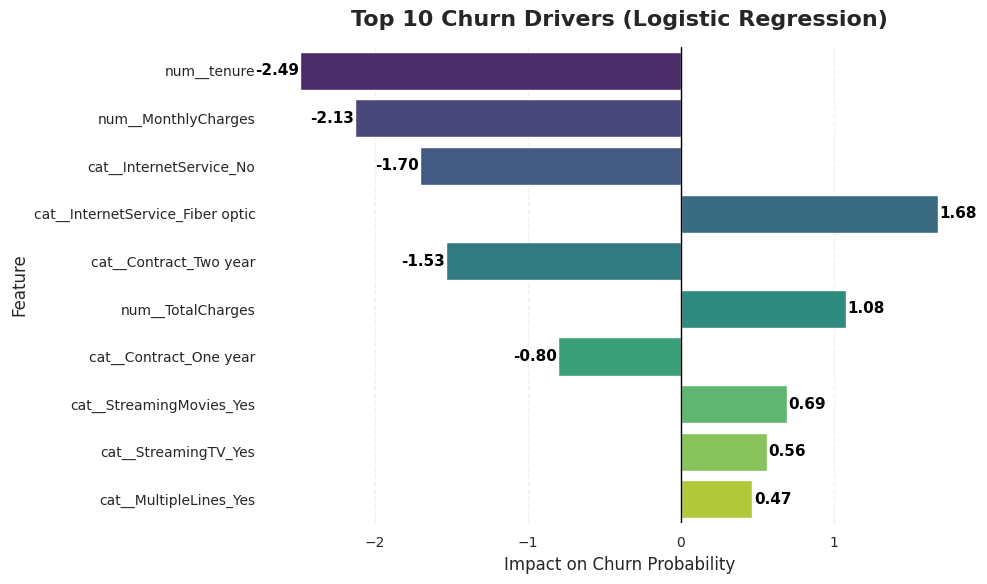

In [128]:
# Sort by absolute magnitude (total effect)
top_drivers['Abs_Col'] = top_drivers['Coefficient'].abs()
top_drivers = top_drivers.sort_values(by='Abs_Col', ascending=False).head(10)

#  Visualization
plt.figure(figsize=(10, 6))
plot = sns.barplot(
    data=top_drivers,
    x="Coefficient",
    y="Feature",
    palette="viridis"  # Neutral palette for regression coefficients
)

# Annotate coefficient values on each bar
for i, v in enumerate(top_drivers["Coefficient"]):
    offset = 0.01 if v > 0 else -0.01
    ha = 'left' if v > 0 else 'right'
    plt.text(v + offset, i, f'{v:.2f}', color='black', va='center', ha=ha, fontweight='bold', fontsize=11)

# Labels and title
plt.title("Top 10 Churn Drivers (Logistic Regression)", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Impact on Churn Probability", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.axvline(0, color='black', linewidth=1)  # Baseline at zero
plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine(left=True, bottom=True)  # Remove top and right borders

plt.tight_layout()
plt.show()


**Key Findings from Top Churn Drivers**

The analysis of the **Top 10 churn drivers** confirms patterns consistent with telecommunications literature and the controlled experiments conducted in this notebook:

- **Early churn:** New customers (short tenure) have a higher probability of leaving.  
- **Long-term contracts as a churn barrier:** 1- and 2-year contracts significantly reduce churn risk.  
- **Premium services and risk:** Fiber optic and streaming services increase moderate churn risk, requiring priority attention.  
- **Price is not the main driver:** Pricing alone does not predict churn; its impact is smaller than structural factors (tenure, contract, services).  

These insights enable **actionable business rules** that can be directly integrated into the ML pipeline: early retention campaigns, active monitoring of premium customers, and promotion of longer-term contracts.

---


## **11. Insights**

This notebook documents controlled experiments with different **preprocessing setups, scaling, and data balancing techniques (SMOTE)**, as well as **feature engineering experiments**:

**Final Model Decision:**  
- **Selected model:** Logistic Regression + Numeric Scaling + SMOTE (training only)  
- **Technical justification:** Optimal balance of performance and stability, with consistent Recall ~0.79 and ROC-AUC ~0.84.  
- **Interpretability:** Direct coefficient analysis allows linking business insights to operational action.  

**Threshold Optimization:**  
- **Selected threshold:** 0.35 to maximize Recall and minimize costly False Negatives.  
- **Result:** Recall ~90%, accepting increased False Positives, consistent with proactive retention strategies.  

**Impact of Experiments:**  
- Numeric scaling and SMOTE significantly improved Recall performance.  
- Additional feature engineering and more complex models (Random Forest) did **not provide meaningful improvements**, and increased complexity and reduced interpretability.  
- Stratified validation and end-to-end pipelines ensured **robustness and prevention of data leakage**.

---

### Final Takeaways

- **Early churn detection is critical:** Customers with short tenure require early intervention.  
- **Contract type is the strongest lever:** Long-term contracts consistently reduce churn.  
- **Model simplicity wins:** Logistic Regression combines stability, scalability, and interpretability, making it ideal for MVP and production deployment.  
- **Business rules are actionable:** Generated insights allow prioritization of retention campaigns and monitoring of high-risk customers without significant operational cost increases.  
- **Notebook as a blueprint for production:** All findings, charts, and experiments documented here form the basis of a reproducible ML pipeline, with clearly defined metrics, thresholds, and business rules.

---

**Conclusion:**  
This notebook demonstrates that a controlled EDA approach, combined with preprocessing experiments and model testing, enables the identification of critical churn drivers, optimization of an interpretable model, and generation of actionable business rules ready for production and scalability. This analysis forms the cornerstone of the ML pipeline for customer retention in telecommunications.